***
<font size="6"><center><b> H-CapsNet: A Capsule Network for Hierarchical Image Classification </b></center></font>
***

# Model Description

**H-CapsNet model:**
- Use Capsule network for hierarchcial classification
- This model contains a deducated feature extraction layer and Capsule netowrk per hierarchy
- For training use MixupData data augmentation technique
- Model Uses Dynamic LossWeight Distribution system
- This model is designed and evaluted using **TensorFlow 2.8.0**

# Import necessary Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
    # ML model, Dataset and evalution metrics
from models import datasets
from models import MLmodel
from models import metrics
from models import MixUp
    # For developind (reloades any python scripts)
import importlib
# importlib.reload(MLmodel)


DONE


In [2]:
%load_ext autoreload
%autoreload 2

# Print System Information

In [3]:
try:
    print('\033[91m','\033[1m',"\n\u2022","COMPUTER NAME =", '\033[0m',os.environ['COMPUTERNAME'])
except:
    print('\033[91m','\033[1m',"\n\u2022","COMPUTER NAME =", '\033[0m',os.name)
print('\033[91m','\033[1m',"\n\u2022","WORKING DIRECTORY: ",'\033[0m',os.getcwd())
print('\033[91m','\033[1m',"\n\u2022","python version = ", '\033[0m', sys.version,)
print('\033[91m','\033[1m',"\n\u2022","tensorflow version = " ,'\033[0m',tf.__version__)
print('\033[91m','\033[1m',"\n\u2022","keras version = ", '\033[0m',tf.keras.__version__)
try:
  print('\033[91m','\033[1m',"\n\u2022","Current Anaconda Environment =", '\033[0m',os.environ['CONDA_DEFAULT_ENV'])
except:
  print('\033[91m','\033[1m',"\n\u2022","Not Using Anaconda", '\033[0m')

  
• COMPUTER NAME =  30BFPC1AXW95
  
• WORKING DIRECTORY:   D:\GitHub\H-CapsNet_A-Capsule-Network-for-Hierarchical-Image-Classification
  
• python version =   3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
  
• tensorflow version =   2.8.0
  
• keras version =   2.8.0
  
• Current Anaconda Environment =  py38tf


# Defining GPU memory growth

In [4]:
! nvidia-smi --list-gpus

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-40c1a3ca-27b3-3f4c-5286-ebba95c166bd)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Done: GPU "+str(gpu))
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Training parameters

## LOG Directory

In [6]:
def log_dir(name: str):
    """
    Create a log directory and returen the directory as String
    """
    base_path = "./logs/"+name
    if not os.path.exists(base_path):
        os.makedirs(base_path)
        print("FOLDER CREATED = ", base_path)
    else:
        print("Warning: Folder already exist.")
    return base_path

## Parameters

In [15]:
train_params = {"n_epochs" : 50,
                "batch_size": 128,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
               }
CapsNet = {"P_Cap_Dim" : 8, # Primary Capsule Dimentions
           "S_Cap_Dim" : 16, # Secondary Capsule Dimention
           "Reconstruction_LW" : 0.0005 # Decoder loss weight
          }

# MNIST dataset

## Import MNIST dataset

dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree', 'name'])
Root
├── Coarse_0
│   ├── Fine_0
│   └── Fine_6
├── Coarse_1
│   ├── Fine_2
│   └── Fine_8
├── Coarse_2
│   ├── Fine_1
│   └── Fine_7
├── Coarse_3
│   ├── Fine_4
│   └── Fine_9
└── Coarse_4
    ├── Fine_3
    └── Fine_5

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 5)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(60000, 5)
Number of Classes in Label Tree: 
Coarse Level =  5 
Fine Level =  10


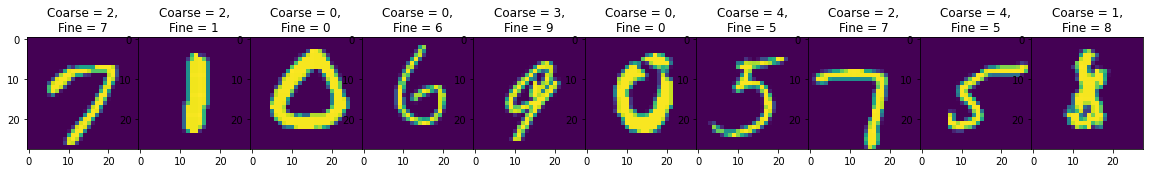

In [98]:
## Import dataset
dataset = datasets.MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('Number of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)

    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

## Create ML Model

### Model parameters

In [112]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class, "fine": fine_class})
coarse_lw = K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw") # Loss Weight for Coarse Class
fine_lw = K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw") # Loss Weight for Fine Class

def get_compiled_model():
    model = MLmodel.MNIST_HCapsNet(input_shape,
                                   coarse_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[MLmodel.MarginLoss(),
                        MLmodel.MarginLoss(),
                        'mse'],
        loss_weights=[coarse_lw, fine_lw, CapsNet["Reconstruction_LW"]],
        metrics={'Fine_prediction_output_layer': 'accuracy',
                 'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

Model: "H-CapsNet_MNIST"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 32)   320         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization_51 (BatchN  (None, 26, 26, 32)  128         ['conv1[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 conv2 (Conv2D)                 (None, 24, 24, 64)   18496       ['batch_normalizati

Trainable params: 10,382,577
Non-trainable params: 3,008
__________________________________________________________________________________________________


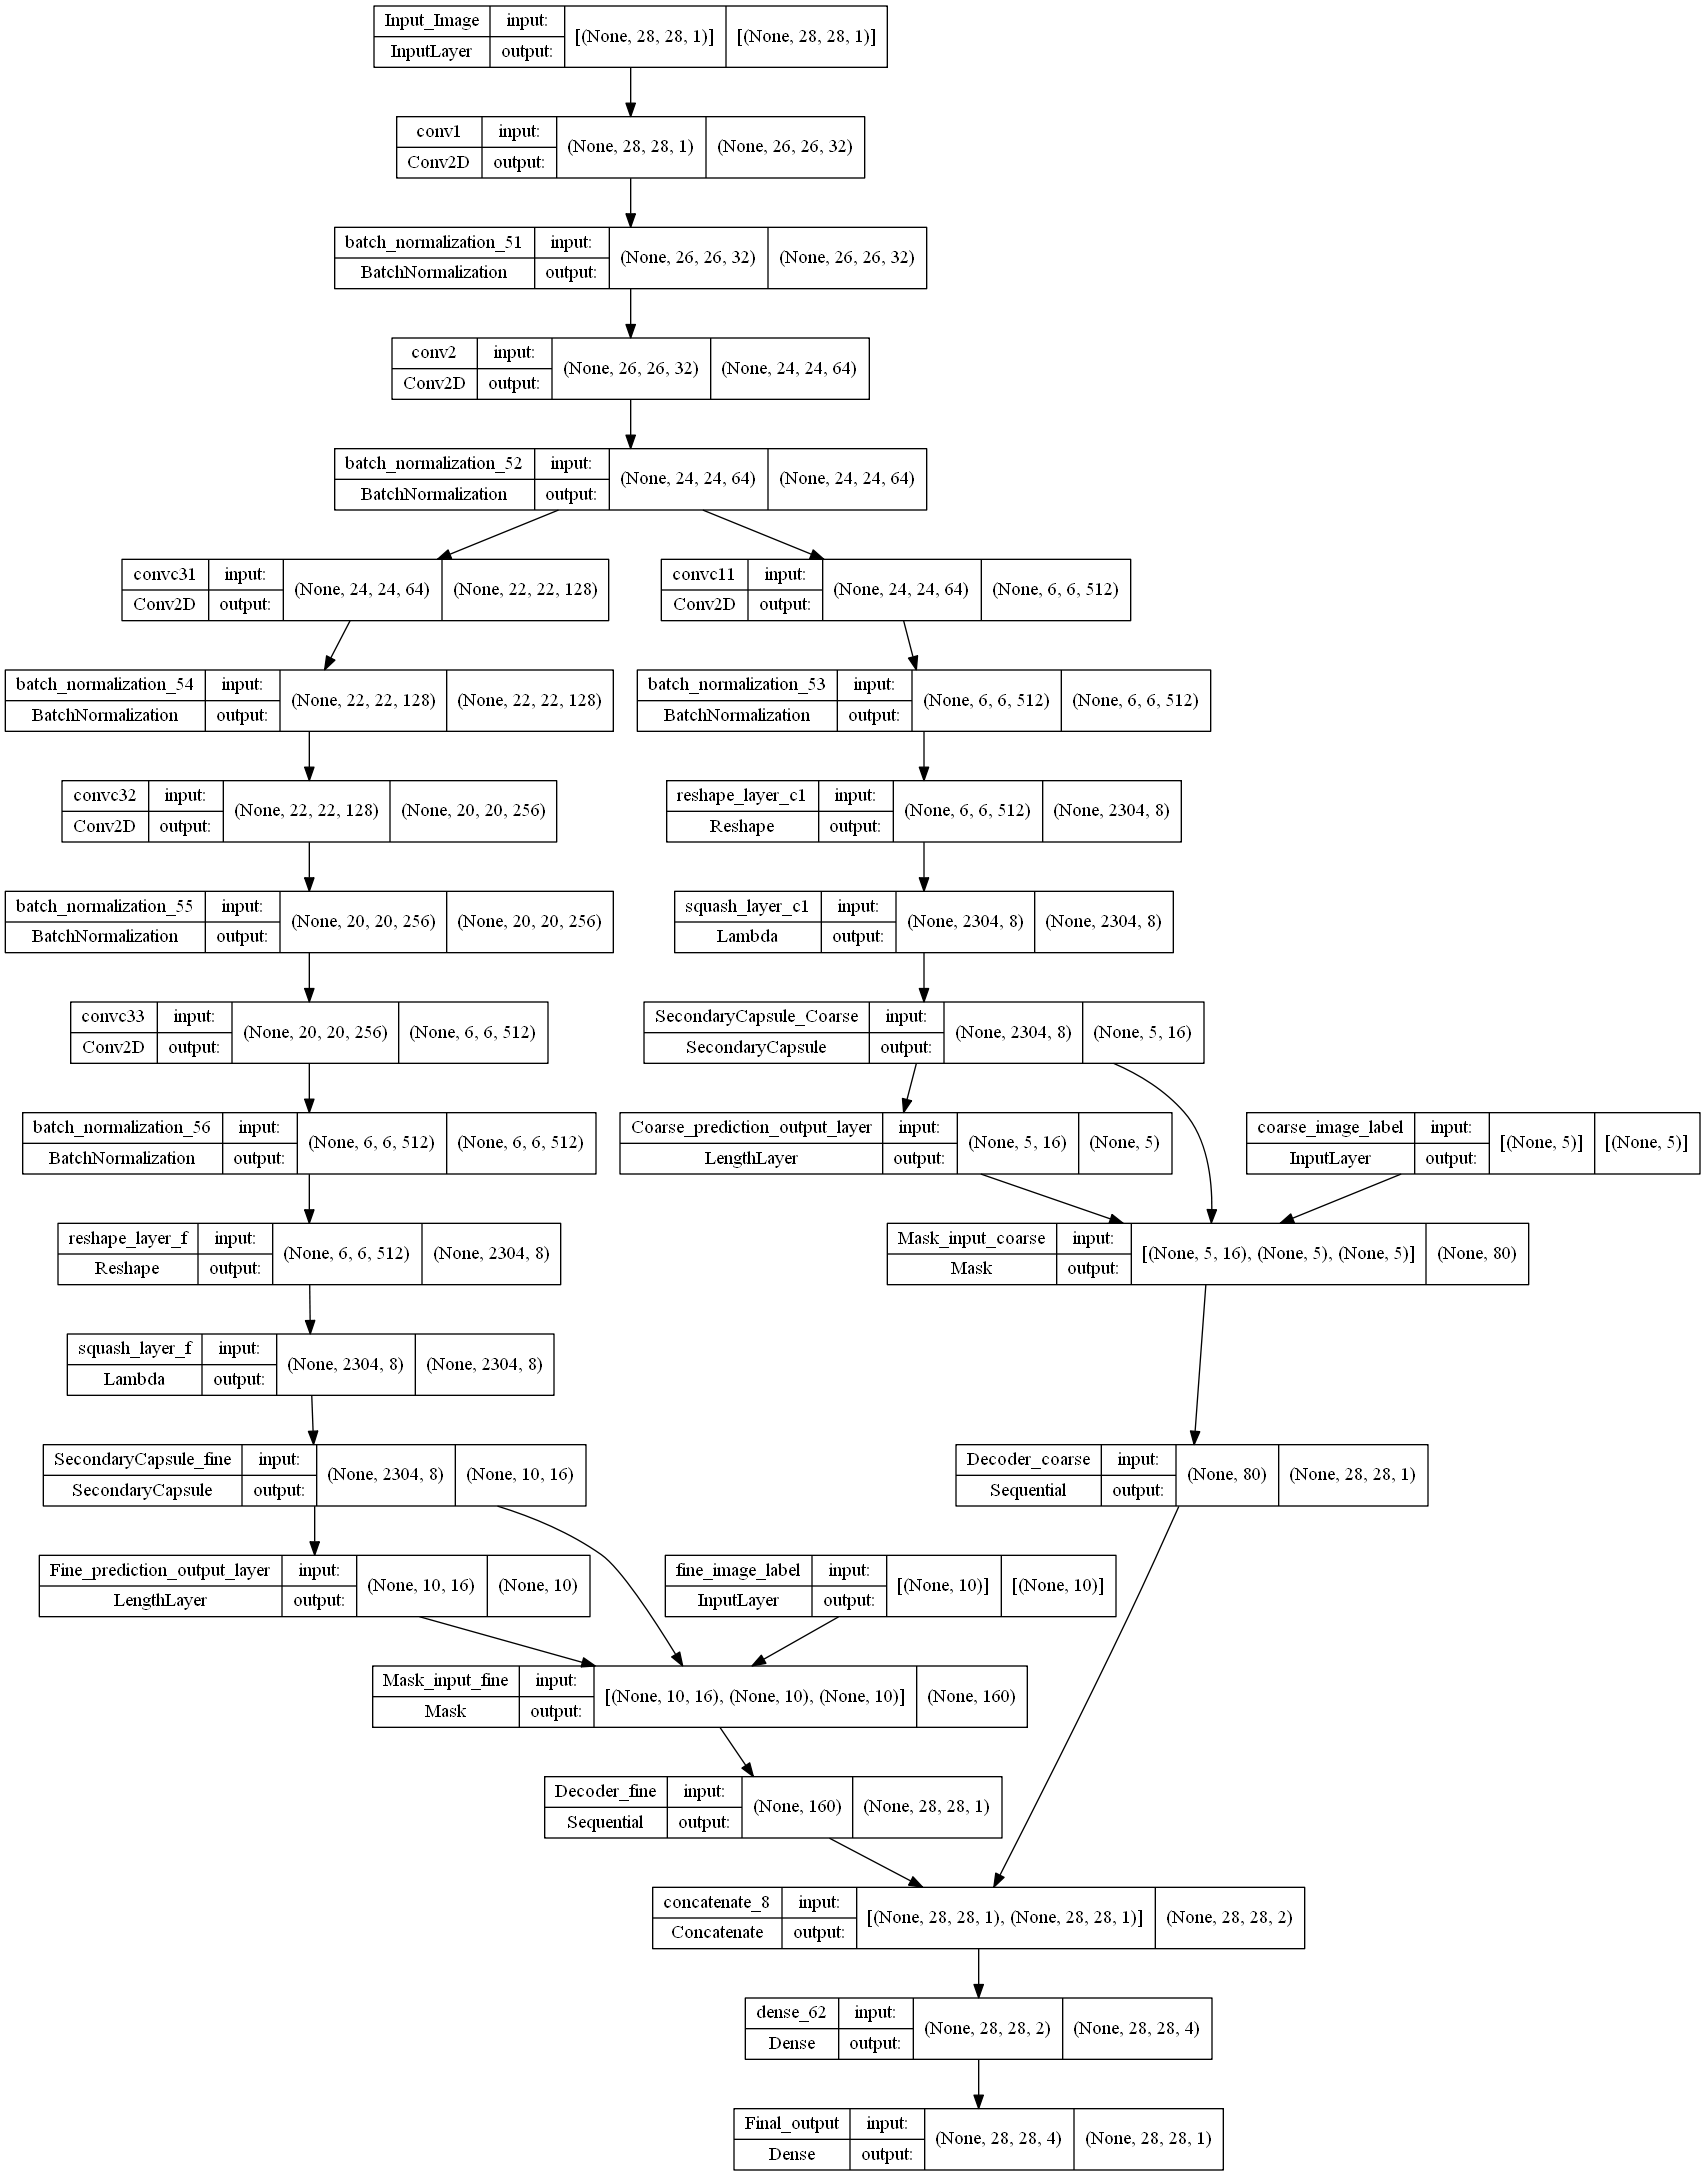

In [121]:
model = get_compiled_model()

### Log directory
directory = log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

### Callbacks

In [ ]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs')
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_Fine_prediction_output_layer_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(coarse_lw, fine_lw)

## Training Model

## Model Analysis

# EMNIST Dataset

## Import EMNIST dataset

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']
Complete loading training samples as: x_train, y_train
Complete loading test samples as: x_test, y_test
dict_keys(['x_train', 'y_train_coarse', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_fine', 'tree'])
Root
├── Coarse_0
│   ├── Fine_0
│   ├── Fine_1
│   ├── Fine_2
│   ├── Fine_3
│   ├── Fine_4
│   ├── Fine_5
│   ├── Fine_6
│   ├── Fine_7
│   ├── Fine_8
│   └── Fine_9
└── Coarse_1
    ├── Fine_10
    ├── Fine_11
    ├── Fine_12
    ├── Fine_13
    ├── Fine_14
    ├── Fine_15
    ├── Fine_16
    ├── Fine_17
    ├── Fine_18
    ├── Fine_19
    ├── Fine_20
    ├── Fine_21
    ├── Fine_22
    ├── Fine_23
    ├── Fine_24
    ├── Fine_25
    ├── Fine_26
    ├── Fine_27
    ├── Fine_28
    ├── Fine_29
    ├── Fine_30
    ├── Fine_31
    ├── Fine_32
    ├── Fine_33
    ├── Fine_34
    ├── Fine_35
    ├── Fine_36
    ├── Fine_37
    ├── Fine_38
    ├── Fine_39
    ├── Fine_40
    ├── Fine_41
    ├── Fine_42
    ├── Fine_43

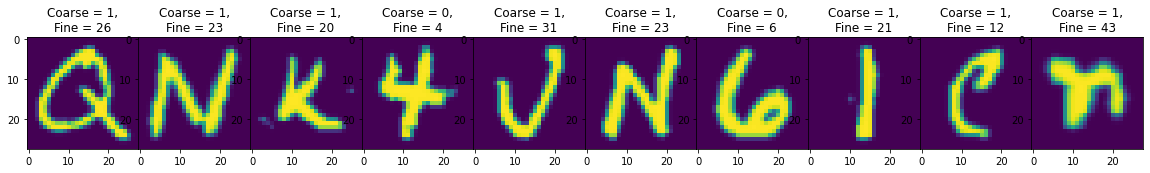

In [22]:
## Import dataset
dataset = datasets.E_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('Number of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nFine Level = ',fine_class)
    # Plot Random samples 
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'fine':dataset['y_train_fine']})

# Fashion-MNIST dataset

## Import Fashion-MNIST dataset

dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_0
│   │   ├── Fine_2
│   │   └── Fine_6
│   ├── Medium1
│   │   └── Fine_1
│   ├── Medium2
│   │   └── Fine_3
│   └── Medium3
│       └── Fine_4
└── Coarse_1
    ├── Medium4
    │   └── Fine_8
    └── Medium5
        ├── Fine_5
        ├── Fine_7
        └── Fine_9

INPUT SHAPE: (28, 28, 1) 

TRAIN: 

(60000, 28, 28, 1)
(60000, 10)
(60000, 6)
(60000, 2)

TEST: 

(10000, 28, 28, 1)
(10000, 10)
(60000, 6)
(60000, 2)
Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  6 
Fine Level =  10


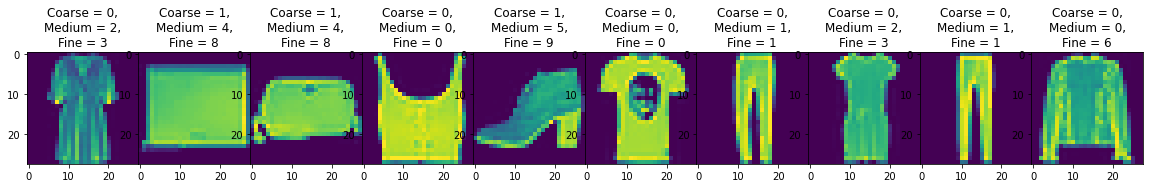

In [92]:
## Import dataset
dataset = datasets.F_MNIST()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('Number of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

# CIFAR-10 Dataset

## Import CIFAR-10 dataset

In [71]:
## Import dataset
dataset = datasets.CIFAR10()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('Number of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree'])
Root
├── Coarse_0
│   ├── Medium0
│   │   └── Fine_0
│   ├── Medium1
│   │   └── Fine_8
│   └── Medium2
│       ├── Fine_1
│       └── Fine_9
└── Coarse_1
    ├── Medium3
    │   └── Fine_2
    ├── Medium4
    │   └── Fine_6
    ├── Medium5
    │   ├── Fine_3
    │   └── Fine_5
    └── Medium6
        ├── Fine_4
        └── Fine_7

INPUT SHAPE: (32, 32, 3) 

TRAIN: 

(50000, 32, 32, 3)
(50000, 10)
(50000, 7)
(50000, 2)

TEST: 

(10000, 32, 32, 3)
(10000, 10)
(50000, 7)
(50000, 2)
Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  7 
Fine Level =  10


# CIFAR-100 Dataset

## Import CIFAR-100 dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree'])
Root
├── Coarse_0
│   ├── Medium0
│   │   ├── Fine_30
│   │   ├── Fine_4
│   │   ├── Fine_55
│   │   ├── Fine_72
│   │   └── Fine_95
│   └── Medium1
│       ├── Fine_1
│       ├── Fine_32
│       ├── Fine_67
│       ├── Fine_73
│       └── Fine_91
├── Coarse_1
│   ├── Medium17
│   │   ├── Fine_47
│   │   ├── Fine_52
│   │   ├── Fine_56
│   │   ├── Fine_59
│   │   └── Fine_96
│   ├── Medium2
│   │   ├── Fine_54
│   │   ├── Fine_62
│   │   ├── Fine_70
│   │   ├── Fine_82
│   │   └── Fine_92
│   └── Medium4
│       ├── Fine_0
│       ├── Fine_51
│       ├── Fine_53
│       ├── Fine_57
│       └── Fine_83
├── Coarse_2
│   ├── Medium3
│   │   ├── Fine_10
│   │   ├── Fine_16
│   │   ├── Fine_28
│   │   ├── Fine_61
│   │   └── Fine_9
│   ├── Medium5
│   │   ├── Fine_22
│   │   ├── Fine_39
│   │   ├── Fine_40
│   │   ├── Fine_86
│   │   └── Fine_87
│   └

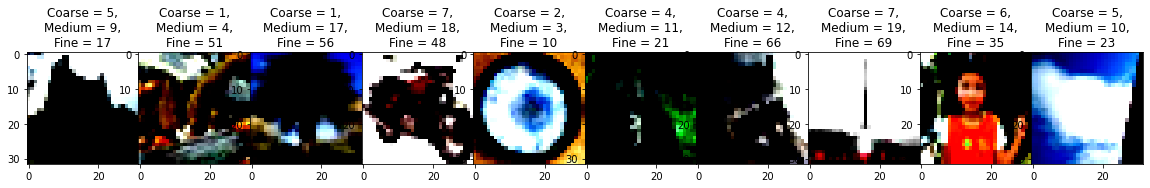

In [93]:
## Import dataset
dataset = datasets.CIFAR100()
print(dataset.keys())
dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_test_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('Number of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)

datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

## Create ML model

In [24]:
model = MLmodel.CIFAR100_HCapsNet(input_shape,
                               coarse_class, medium_class, fine_class)
model.summary()

## Model Training

## Model Analysis